In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

from IPython.display import display

PATH = "C:/Users/brian/Documents/Research/galaxies"

In [16]:
c_nmad = '#8888ed'
c_median = '#ce1504'
c_rmse = '#ce1504'

In [17]:
all_info = pd.read_csv(f"C:/Users/brian/Documents/Research/galaxies/sdss_dr18_all.csv", dtype={'objID' : str})

preds = pd.read_csv(f"C:/Users/brian/Documents/Research/galaxies/results/results_inceptionres.csv", dtype={'objID' : str})


In [18]:
all_info = all_info.rename(columns = {'oh_p50' : 'metallicity', "lgm_tot_p50" : "log_mass_photometry", "lgm_fib_p50" : "log_mass_fibre"})

In [19]:
preds.head()

,objID,metallicity,predicted_metallicity
0,1237660613972525118,9.052573,9.011690
1,1237651753463775396,8.681310,8.824460
2,1237661382777634958,9.001761,8.980931
3,1237678617936920824,8.671819,8.715862
4,1237652900238328080,9.103011,9.088113


In [20]:
all_info = all_info.drop(columns = ['metallicity'])

In [21]:
all_info.head()

,objID,specObjID,ra,dec,log_mass_photometry,log_mass_fibre,z
0,1237656240623583493,827537023546976256,332.917710,11.673843,10.021030,9.594558,0.061899
1,1237656240623583459,827538947692324864,332.893885,11.694876,9.697558,8.943757,0.060581
2,1237656494565294523,827540871837673472,333.202574,11.997486,10.251220,9.880844,0.128244
3,1237656494565359696,827541421593487360,333.237076,12.006926,10.055510,9.631754,0.059419
4,1237652942627078710,827543895494649856,333.404251,12.404971,10.216260,9.757959,0.083776


In [22]:
df = preds.merge(all_info, how = 'inner', on = 'objID')

In [23]:
df.head()

,objID,metallicity,predicted_metallicity,specObjID,ra,dec,log_mass_photometry,log_mass_fibre,z
0,1237660613972525118,9.052573,9.011690,1374760116292708352,167.292444,9.497709,10.033330,9.557298,0.075091
1,1237651753463775396,8.681310,8.824460,567463487509391360,157.905439,1.998087,9.658701,8.760873,0.030645
2,1237661382777634958,9.001761,8.980931,1610201843894347776,159.749390,39.358153,10.390840,9.726973,0.076200
3,1237678617936920824,8.671819,8.715862,1156396004249987072,319.422546,0.924328,9.944123,9.384727,0.092854
4,1237652900238328080,9.103011,9.088113,523581696755394560,62.383923,-5.747747,10.159940,9.691042,0.074687


In [24]:
# Freedman-Diaconis bin size rule
binsize_true = 2 * (df.metallicity.quantile(0.75) - df.metallicity.quantile(0.25)) * df.metallicity.size**(-1/3)
print(f'True Z binsize: {binsize_true:.4f}')

binsize_pred = 2 * (df.predicted_metallicity.quantile(0.75) - df.predicted_metallicity.quantile(0.25)) * df.predicted_metallicity.size**(-1/3)
print(f'Predicted Z binsize: {binsize_pred:.4f}')

bins = 40
center = 8.7

histrange_true = [center - bins * binsize_true, center + bins * binsize_true]
histrange_pred = [center - bins * binsize_pred, center + bins * binsize_pred]

True Z binsize: 0.0292
Predicted Z binsize: 0.0251


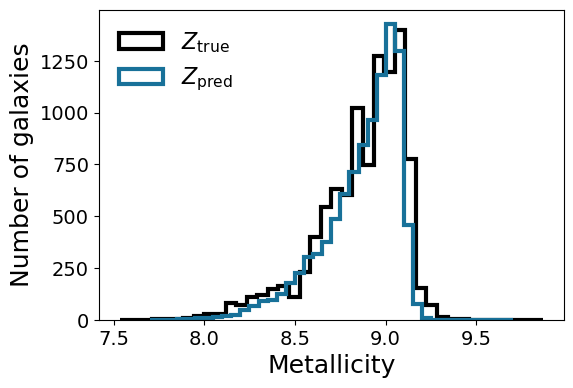

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(df.metallicity, bins=bins, range=histrange_true, color='k', histtype='step', lw=3, label=r'$Z_{\rm true}$');
ax.hist(df.predicted_metallicity, bins=bins, range=histrange_pred, color='#187199', histtype='step', lw=3, ls='-', label=r'$Z_{\rm pred}$')

ax.legend(fontsize=16, loc='upper left', frameon=False)

fig.subplots_adjust(left=0.175, bottom=0.175, right=0.95, top=0.95)

ax.tick_params(labelsize=14)
ax.set_xlabel('Metallicity', fontsize=18)
ax.set_ylabel('Number of galaxies', fontsize=18);

fig.savefig(f'C:/Users/brian/Documents/Research/galaxies/results/03-Z_distribution.pdf')

In [48]:
res = df.predicted_metallicity - df.metallicity

In [49]:
binsize_res = 2 * (res.quantile(0.75) - res.quantile(0.25)) * res.size**(-1/3)
print(f'Bin size: {binsize_res:.4f}')

bins = 40
center_res = 0

histrange_res = [-bins * binsize_res, bins * binsize_res]

Bin size: 0.0106


Center: -0.0117


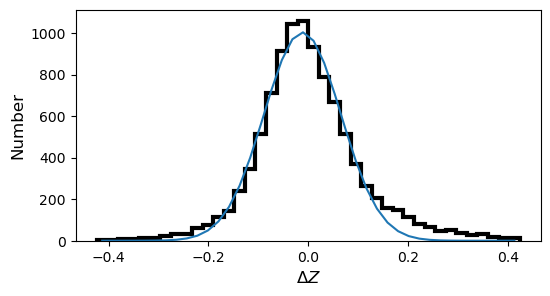

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

n, bin_edges, _ = ax.hist(res, bins=bins, range=histrange_res, color='k', histtype='step', lw=3)

# fit gaussian
def gaussian(x, amp, mu, std): 
    return amp*np.exp(-(x-mu)**2 / (2*std**2))

def mse_loss(params, x, y):
    return np.sum((gaussian(x, *params) - y)**2)
    

bin_centers = (bin_edges[:-1]+bin_edges[1:]) / 2

result = minimize(mse_loss, [1500, 0, 0.07], args=(bin_centers, n))

fit_normal = gaussian(bin_centers, *result['x'])

ax.plot(bin_centers, fit_normal, label='Best fit normal')

print(f'Center: {result["x"][1]:.04f}')

ax.set_xlabel('$\Delta Z$', fontsize=12)
ax.set_ylabel('Number', fontsize=12);

Text(0.5, 0, '$\\Delta Z$')

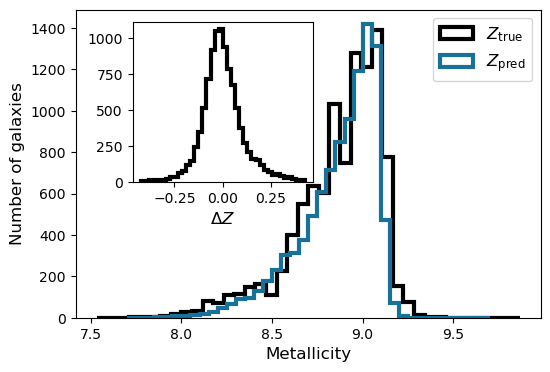

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(df.metallicity, bins=bins, range=histrange_true, color='k', histtype='step', lw=3, label=r'$Z_{\rm true}$');
ax.hist(df.predicted_metallicity, bins=bins, range=histrange_pred, color='#187199', histtype='step', lw=3, ls='-', label=r'$Z_{\rm pred}$')

ax.legend(fontsize=12, loc='upper right')

ax.set_xlabel('Metallicity', fontsize=12)
ax.set_ylabel('Number of galaxies', fontsize=12);

# inset plot

ax_inset = fig.add_axes([0.22, 0.45, 0.3, 0.4])

n, bin_edges, _ = ax_inset.hist(res, bins=bins, range=histrange_res, color='k', histtype='step', lw=3)

ax_inset.set_xlabel('$\Delta Z$', fontsize=12)

In [65]:
def load_image(idx, df, ax=None, annotate=True):
    """Helper function to load and annotate image"""
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        
    Z_true, Z_pred = df.iloc[idx]
    name = df.index[idx]
    
    # get image
    image = plt.imread(f'{PATH}/images_alt/{name}.jpg')
    ax.imshow(image)
    ax.axis('off')
    
    # label
    if annotate:
        fontdict = dict(color='white', size=18)
        #ax.text(0.5, 0.9, f'{name}', fontdict=fontdict, transform=ax.transAxes, ha='center', va='bottom')
        ax.text(0.95, 0.125, r'$Z_{\rm true}$' + f' = {Z_true:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')
        ax.text(0.95, 0.025, r'$Z_{\rm pred}$' + f' = {Z_pred:.3f}', fontdict=fontdict, transform=ax.transAxes, ha='right', va='bottom')


In [66]:
preds = pd.read_csv(f"C:/Users/brian/Documents/Research/galaxies/results/results_inceptionres.csv", index_col=0)

In [67]:
preds.head()

,metallicity,predicted_metallicity
objid,,
1237660613972525118,9.052573,9.011690
1237651753463775396,8.681310,8.824460
1237661382777634958,9.001761,8.980931
1237678617936920824,8.671819,8.715862
1237652900238328080,9.103011,9.088113


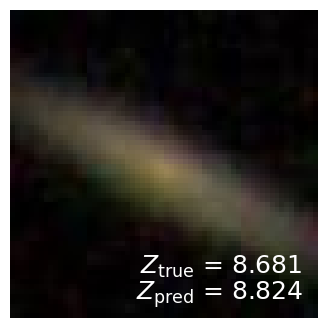

In [68]:
load_image(1, preds)

In [70]:
lowest_Z = preds.sort_values(by='predicted_metallicity', ascending=True)

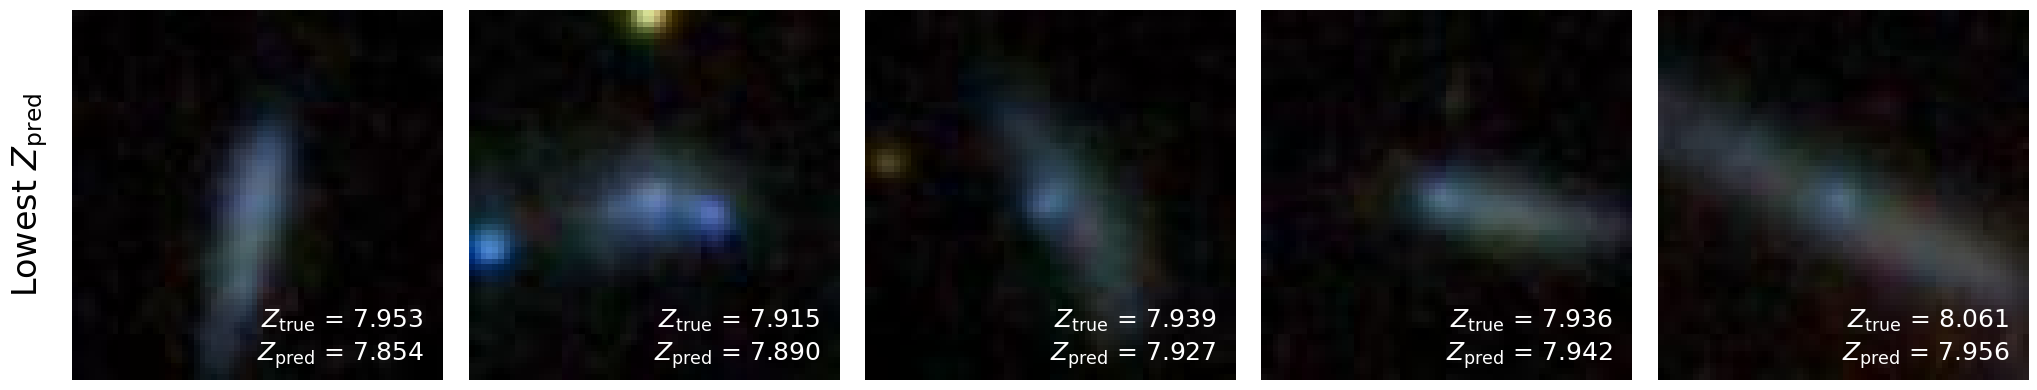

In [81]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, lowest_Z, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(-0.02, 0.5, r'Lowest $Z_{\rm pred}$', rotation=90, fontsize=24, va='center');

In [75]:
highest_Z = preds.sort_values(by='predicted_metallicity', ascending=False)

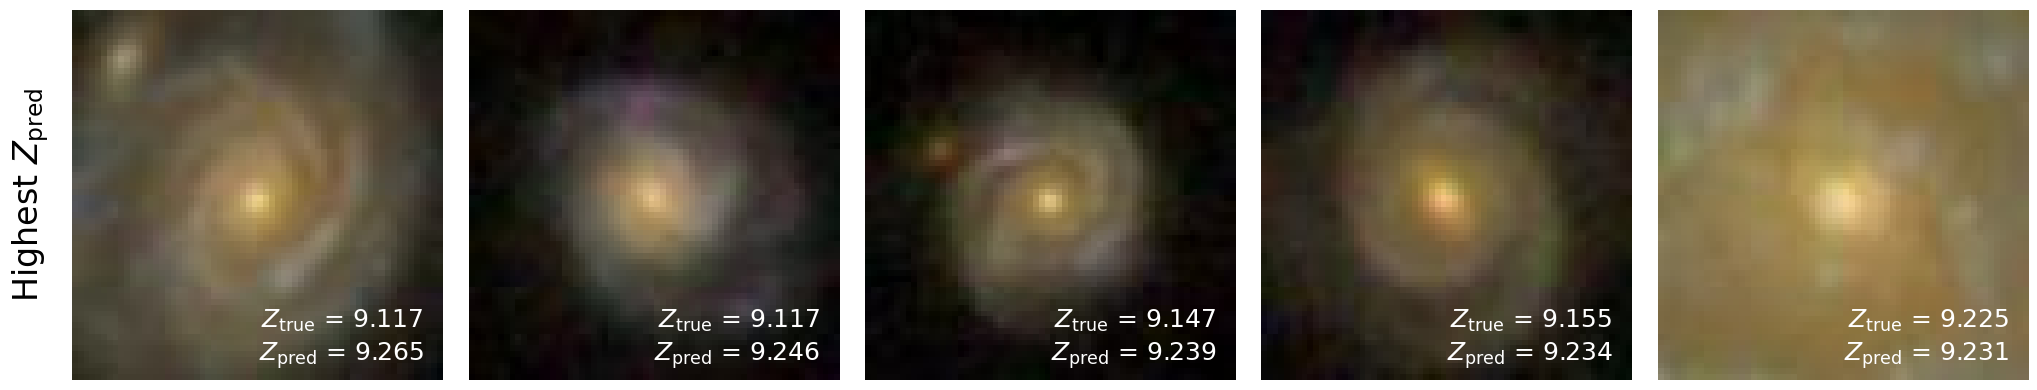

In [80]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, highest_Z, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(-0.02, 0.5, r'Highest $Z_{\rm pred}$', rotation=90, fontsize=24, va='center');

In [83]:
underestimated = preds.iloc[np.argsort(preds.predicted_metallicity - preds.metallicity)]
underestimated.head()

,metallicity,predicted_metallicity
objid,,
1237661966894170372,8.843028,8.092741
1237659896173953200,8.969268,8.235348
1237651272964571245,9.170148,8.460580
1237651273502752910,9.269875,8.651018
1237659145631367270,9.361573,8.777655


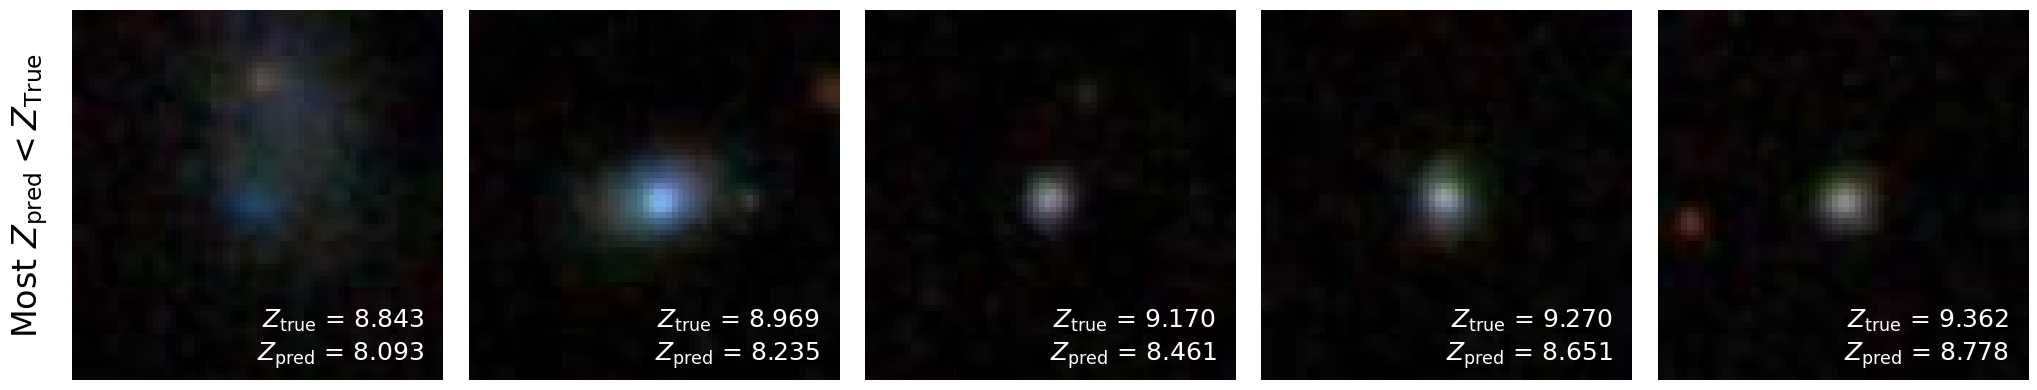

In [84]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, underestimated, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(-0.02, 0.5, r'Most $Z_{\rm pred} < Z_{\rm True}$', rotation=90, fontsize=24, va='center');

In [85]:
overestimated = preds.iloc[np.argsort(preds.metallicity - preds.predicted_metallicity)]
overestimated.head()

,metallicity,predicted_metallicity
objid,,
1237649961921282185,7.747077,8.812211
1237651496296382666,8.009755,8.862246
1237678596461559971,8.075785,8.866879
1237663783136067708,8.123260,8.904278
1237655470208516255,7.851740,8.615137


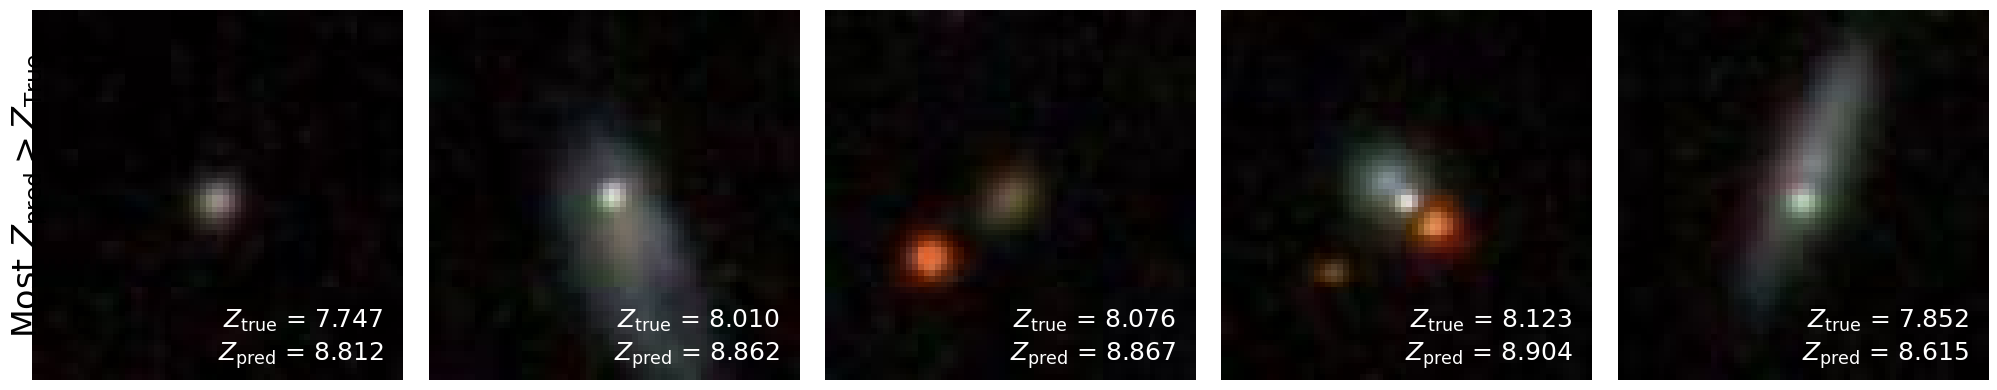

In [86]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, overestimated, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(-0.02, 0.5, r'Most $Z_{\rm pred} > Z_{\rm True}$', rotation=90, fontsize=24, va='center');

In [88]:
highest_Z_true = preds.sort_values(by='metallicity', ascending=False)
lowest_Z_true = preds.sort_values(by='metallicity', ascending=True)

In [90]:
rand = preds.sample(frac=1., random_state=42)

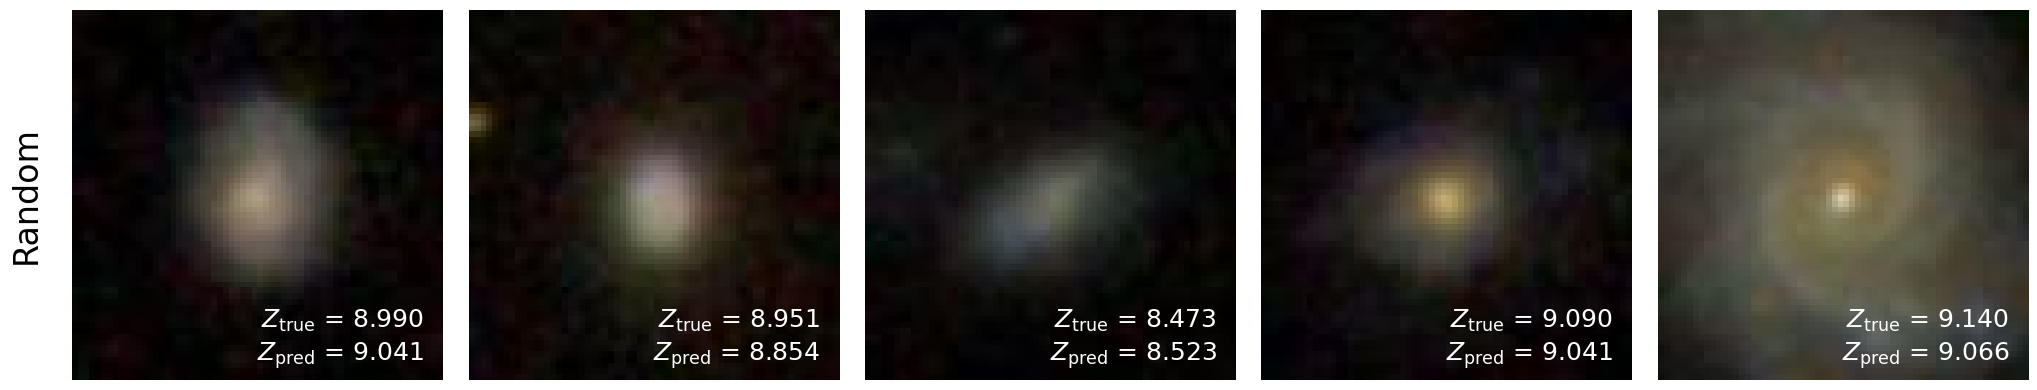

In [91]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, rand, ax=ax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03)
fig.text(-0.02, 0.5, r'Random', rotation=90, fontsize=24, va='center');

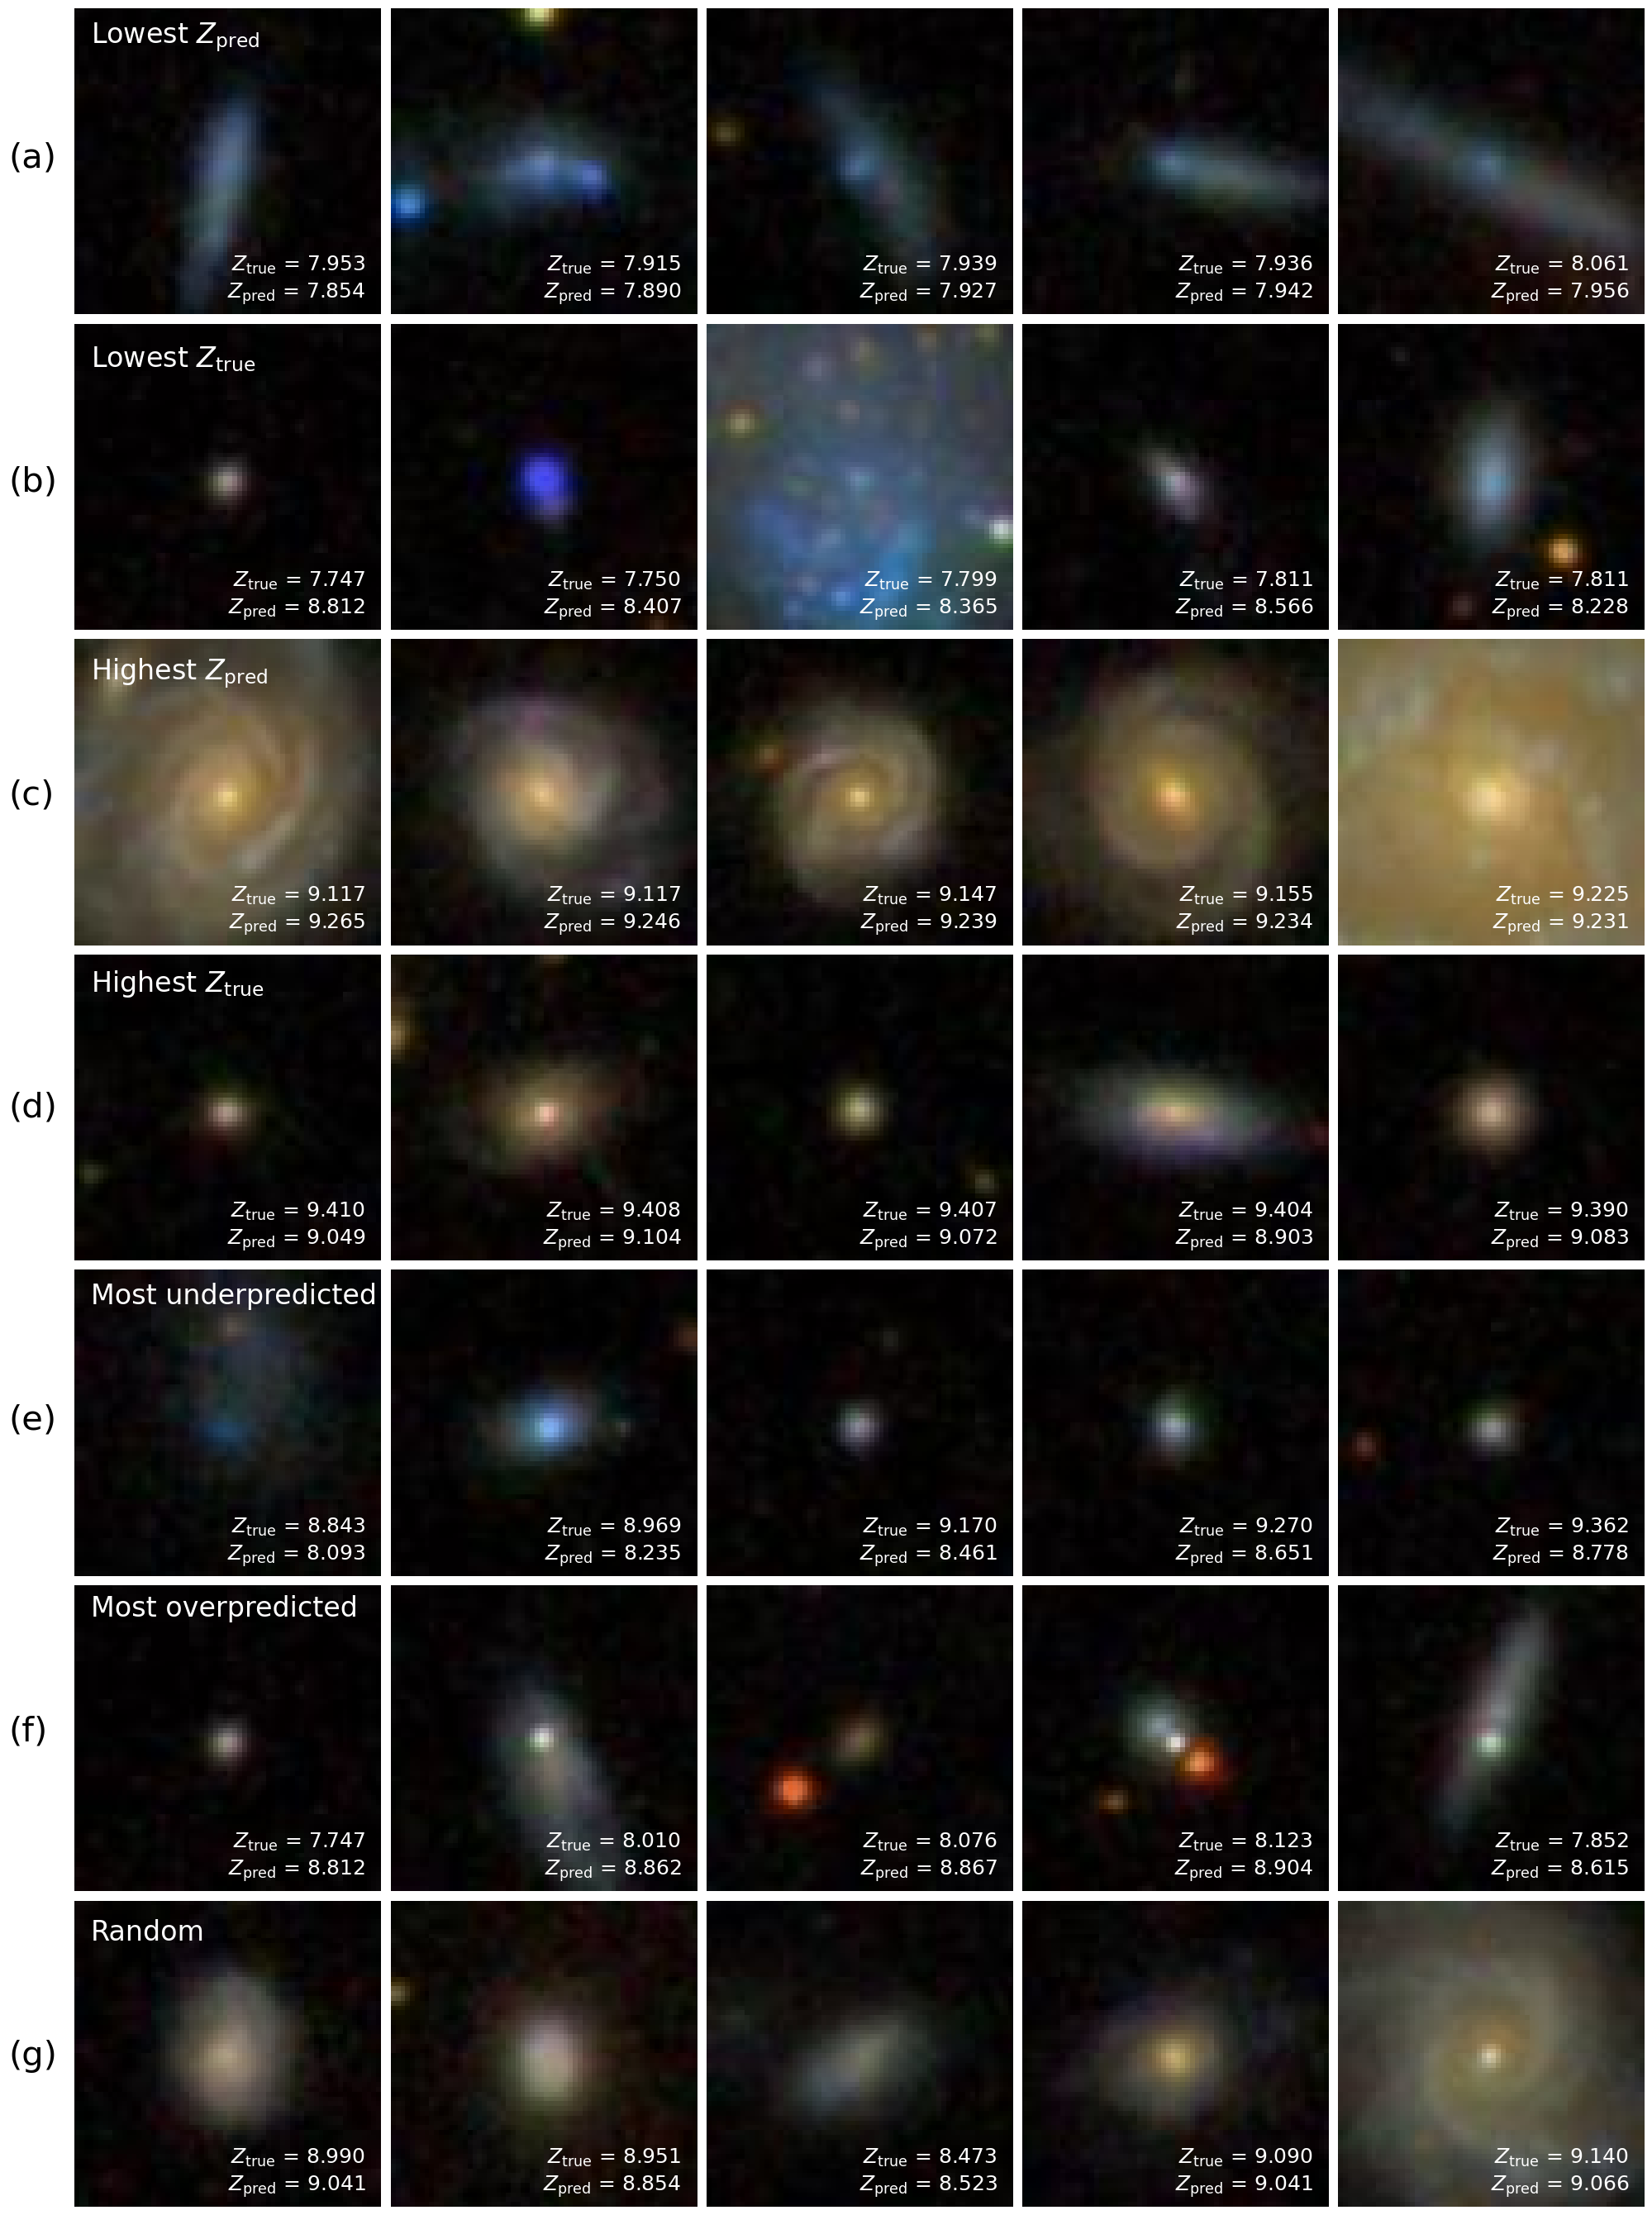

In [188]:
fig, axes = plt.subplots(7, 5, figsize=(20, 28))

for idx in range(5):
    ax = axes.flat[idx]
    load_image(idx, lowest_Z, ax=ax)
fig.text(0.0, 0.91, '(a)', fontsize=30, va='center')
fig.text(0.05, 0.96, r'Lowest $Z_{\rm pred}$', fontsize=24, color='white')

for idx in range(5):
    ax = axes.flat[5+idx]
    load_image(idx, lowest_Z_true, ax=ax)
fig.text(0.0, 0.77, '(b)', fontsize=30, va='center')
fig.text(0.05, 0.82,  r'Lowest $Z_{\rm true}$', fontsize=24, color='white')

for idx in range(5):
    ax = axes.flat[10+idx]
    load_image(idx, highest_Z, ax=ax)
fig.text(0.0, 0.635, '(c)', fontsize=30, va='center')
fig.text(0.05, 0.685, r'Highest $Z_{\rm pred}$', fontsize=24, color='white')

for idx in range(5):
    ax = axes.flat[15+idx]
    load_image(idx, highest_Z_true, ax=ax)
fig.text(0.0, 0.5, '(d)', fontsize=30, va='center');
fig.text(0.05, 0.55, r'Highest $Z_{\rm true}$', fontsize=24, color='white')

for idx in range(5):
    ax = axes.flat[20+idx]
    load_image(idx, underestimated, ax=ax)
fig.text(0.0, 0.365, '(e)', fontsize=30, va='center')
fig.text(0.05, 0.415, r'Most underpredicted', fontsize=24, color='white')

for idx in range(5):
    ax = axes.flat[25+idx]
    load_image(idx, overestimated, ax=ax)
fig.text(0.0, 0.23, '(f)', fontsize=30, va='center')
fig.text(0.05, 0.28, r'Most overpredicted', fontsize=24, color='white')

for idx in range(5):
    ax = axes.flat[30+idx]
    load_image(idx, rand, ax=ax)
fig.text(0.0, 0.09, '(g)', fontsize=30, va='center')
fig.text(0.05, 0.14, r'Random', fontsize=24, color='white')

fig.tight_layout()
fig.subplots_adjust(wspace=0.03, hspace=0.03, left=0.04, right=0.99, bottom=0.025, top=0.975)

fig.savefig(f'{PATH}/results/01-prediction_examples.pdf')

In [29]:
tremonti_mass  =[8.57,8.67,8.76,8.86,8.96,9.06,9.16,9.26,9.36,9.46,9.57,9.66,9.76,9.86,9.96,10.06,10.16,10.26,10.36,10.46,10.56,10.66,10.76,10.86,10.95,11.05,11.15,11.25]

tremonti_oh2_5 =[8.18,8.11,8.13,8.14,8.21,8.26,8.37,8.39,8.46,8.53,8.59,8.60,8.63,8.67,8.71,8.74,8.77,8.80,8.82,8.85,8.87,8.89,8.91,8.93,8.93,8.92,8.94,8.93] 
tremonti_oh16  =[8.25,8.28,8.32,8.37,8.46,8.56,8.59,8.60,8.63,8.66,8.69,8.72,8.76,8.80,8.83,8.85,8.88,8.92,8.94,8.96,8.98,9.00,9.01,9.02,9.03,9.03,9.04,9.03]
tremonti_oh50  =[8.44,8.48,8.57,8.61,8.63,8.66,8.68,8.71,8.74,8.78,8.82,8.84,8.87,8.90,8.94,8.97,8.99,9.01,9.03,9.05,9.07,9.08,9.09,9.10,9.11,9.11,9.12,9.12]
tremonti_oh84  =[8.64,8.65,8.70,8.73,8.75,8.82,8.82,8.86,8.88,8.92,8.94,8.96,8.99,9.01,9.05,9.06,9.09,9.10,9.11,9.12,9.14,9.15,9.15,9.16,9.17,9.17,9.18,9.18]
tremonti_oh97_5=[8.77,8.84,8.88,8.89,8.95,8.97,8.95,9.04,9.03,9.07,9.08,9.09,9.10,9.12,9.14,9.15,9.16,9.17,9.18,9.21,9.21,9.23,9.24,9.25,9.26,9.27,9.29,9.29]

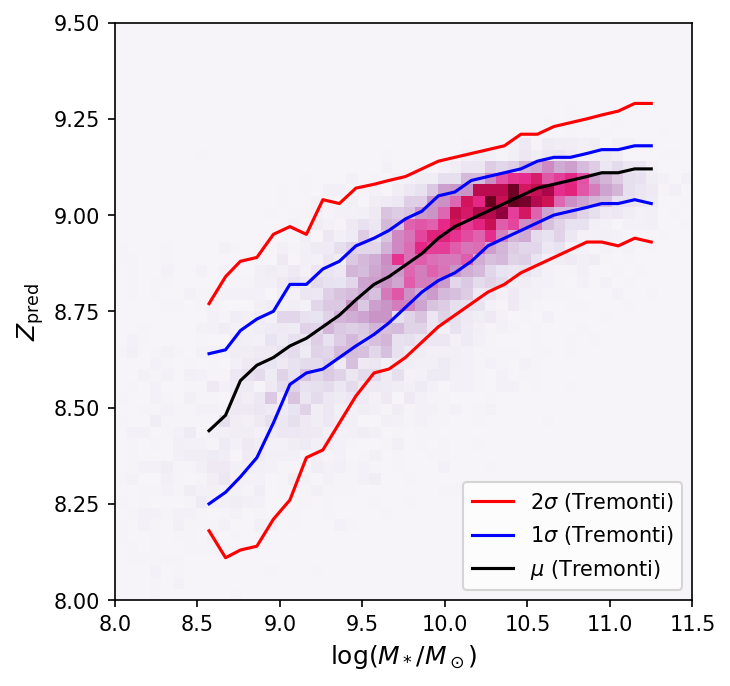

In [31]:
plt.figure(figsize=(5, 5), dpi=150)

masses = df['log_mass_photometry'].tolist()
preds = df['predicted_metallicity'].tolist()

x_min, x_max = 8, 11.5
y_min, y_max = 8, 9.5

plt.hist2d(masses, preds, bins=50, range=[(x_min, x_max), (y_min, y_max)], cmap='PuRd')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect((x_max-x_min)/(y_max-y_min))

plt.xticks(np.arange(x_min, x_max + 0.5, 0.5))
plt.yticks(np.arange(y_min, y_max + 0.25, 0.25))

plt.gca().set_axisbelow(True)

plt.xlabel(r'$\log(M_*/M_\odot)$', fontsize=12)
plt.ylabel(r'$Z_{\rm pred}$', fontsize=12)

plt.plot(tremonti_mass, tremonti_oh2_5, color='red', label='2$\sigma$ (Tremonti)')
plt.plot(tremonti_mass, tremonti_oh16, color='blue', label='1$\sigma$ (Tremonti)')
plt.plot(tremonti_mass, tremonti_oh50, color='black', label='$\mu$ (Tremonti)')
plt.plot(tremonti_mass, tremonti_oh84, color='blue')
plt.plot(tremonti_mass, tremonti_oh97_5, color='red')
plt.legend(loc = 'lower right')

Text(0, 0.5, '$Residual$')

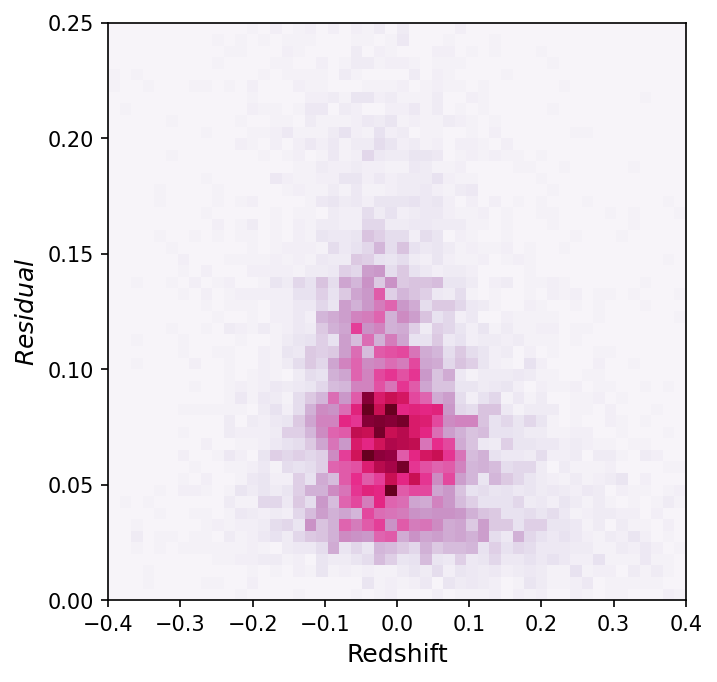

In [43]:
plt.figure(figsize=(5, 5), dpi=150)

masses = df['z'].tolist()
preds = df['predicted_metallicity'].tolist()

x_min, x_max, x_interval = -0.4, 0.4, 0.1
y_min, y_max, y_interval = 0, 0.25, 0.05

plt.hist2d(preds, masses, bins=50, range=[(x_min, x_max), (y_min, y_max)], cmap='PuRd')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect((x_max-x_min)/(y_max-y_min))

plt.xticks(np.arange(x_min, x_max + x_interval, x_interval))
plt.yticks(np.arange(y_min, y_max + y_interval, y_interval))

plt.gca().set_axisbelow(True)

plt.xlabel(r'Redshift', fontsize=12)
plt.ylabel(r'$Residual$', fontsize=12)